In [89]:
import polars.selectors as cs
import numpy as np

import polars as pl

import matplotlib.pyplot as plt

In [111]:
def hist_of_numerical_values(df: pl.DataFrame):
    """
    Generates histograms for all numerical columns in a Polars DataFrame.

    Args:
        df: The Polars DataFrame.

    Returns:
        A dictionary where keys are column names and values are the histogram data.
    """
    histograms = {}
    for col_name in df.columns:
        if df[col_name].dtype in [pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64]:
            hist_data = df[col_name].hist()
            histograms[col_name] = hist_data
    return histograms

In [112]:
index_cols = {
    3: [],
    15: [],
    20: []
}
scale_required = set([15])
# not 8, 14
# skip 3, skip 20
queries_to_run = [15]

In [113]:
query_ind = 20
null_info = {}
orig = pl.read_csv(f'unnoised/q{query_ind}.csv')
noised = pl.read_json(f'outputs/ap-duckdb-q{query_ind}-customer-step3/output.json')
orig = orig.with_row_index(name="rank")
noised = noised.with_row_index(name="rank")
merged_df = orig.join(noised, suffix='_noised',  on="rank")

In [114]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised
u32,str,str,list[str],list[str]
0,"""Supplier#000000157""","""1EmkCApL5iF""","[""Supplier#000000287"", ""Supplier#000000157"", … ""Supplier#000000157""]","[""mLPJtpu4wOc cSFzBR"", ""1EmkCApL5iF"", … ""UQR8bUA4V2HxVbw9K""]"
1,"""Supplier#000000197""","""3oYqODDUGH3XsHXmPuzYHW5NLU3,ON…","[""Supplier#000000197"", ""Supplier#000000555"", … ""Supplier#000000555""]","[""3oYqODDUGH3XsHXmPuzYHW5NLU3,ONZl"", ""UQR8bUA4V2HxVbw9K"", … ""mLPJtpu4wOc cSFzBR""]"
2,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000287"", ""Supplier#000000557"", … ""Supplier#000000530""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""]"
3,"""Supplier#000000378""","""mLPJtpu4wOc cSFzBR""","[""Supplier#000000935"", ""Supplier#000000557"", … ""Supplier#000000530""]","[""IH,v63JRgXMkVhJOJ Gxur0W"", ""mLPJtpu4wOc cSFzBR"", … ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1""]"
4,"""Supplier#000000530""","""0BvoewCPg2scOEfuL93FRKqSxHmdhw…","[""Supplier#000000555"", ""Supplier#000000935"", … ""Supplier#000000555""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4"", … ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1""]"
5,"""Supplier#000000555""","""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""","[""Supplier#000000557"", ""Supplier#000000935"", … ""Supplier#000000555""]","[""IH,v63JRgXMkVhJOJ Gxur0W"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4""]"
6,"""Supplier#000000557""","""IH,v63JRgXMkVhJOJ Gxur0W""","[""Supplier#000000935"", ""Supplier#000000935"", … ""Supplier#000000935""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""IH,v63JRgXMkVhJOJ Gxur0W""]"
7,"""Supplier#000000729""","""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHL…",[null],[null]
8,"""Supplier#000000935""","""JHRSOterYgt4MTNo7cupTzA,6MoNw …",[null],[null]


In [115]:
def get_rel_error_numeric(const, noised_list, actual):
    new = np.average(
        [100*abs(const*noised_list[tmp_ind] - actual) / actual for tmp_ind in range(
                len(noised_list))]
    )
    return new

In [116]:
suffix1 = ''
suffix2 = '_noised'
cols_with_suffixes = [col for col in merged_df.columns if suffix1 in col or suffix2 in col]
base_names = set([col.replace(suffix1, '').replace(suffix2, '') for col in cols_with_suffixes])
for base_name in base_names:
    nulls_exist = False
    null_inds, null_vals = [], []

    orig = base_name + suffix1
    noised = base_name + suffix2
    if orig in merged_df.columns and noised in merged_df.columns:
        rel_errors = []
        for ind in range(len(merged_df[orig])):
            releases = merged_df[noised][ind].to_list()
#             print(releases)
            filtered_releases = [x for x in releases if x is not None]
            if len(filtered_releases) == 0:
                rel_errors.append(None)
                continue
            actual = merged_df[orig][ind]
            try:
                actual = float(actual)
                is_numeric = True
                if actual == 0.0:
                    is_numeric = False # treat 0 as categorical
            except:
                is_numeric = False
            if is_numeric:
#                 print(actual)
                scale_factor = 2 if query_ind in scale_required else 1
                rel_error = get_rel_error_numeric(scale_factor, releases, actual)
            else:
                rel_error = 100-100*releases.count(actual) / len(releases)
            rel_errors.append(rel_error)
        merged_df = merged_df.with_columns(pl.Series('pct_diff_' + base_name, rel_errors))
        num_outputs = len(list(merged_df[noised]))
        for ind in range(num_outputs):
            full_list = [x for x in list(merged_df[noised][ind]) if x is not None]
            if len(full_list) < 100:
                nulls_exist = True
                null_inds.append(ind)
                null_vals.append(100-len(full_list))
                print(query_ind, ind)
    null_info[base_name] = (nulls_exist, null_inds, null_vals)


20 4
20 5
20 6
20 7
20 8
20 4
20 5
20 6
20 7
20 8


In [117]:
merged_df

rank,s_name,s_address,s_name_noised,s_address_noised,pct_diff_s_name,pct_diff_s_address
u32,str,str,list[str],list[str],f64,f64
0,"""Supplier#000000157""","""1EmkCApL5iF""","[""Supplier#000000287"", ""Supplier#000000157"", … ""Supplier#000000157""]","[""mLPJtpu4wOc cSFzBR"", ""1EmkCApL5iF"", … ""UQR8bUA4V2HxVbw9K""]",70.0,75.0
1,"""Supplier#000000197""","""3oYqODDUGH3XsHXmPuzYHW5NLU3,ON…","[""Supplier#000000197"", ""Supplier#000000555"", … ""Supplier#000000555""]","[""3oYqODDUGH3XsHXmPuzYHW5NLU3,ONZl"", ""UQR8bUA4V2HxVbw9K"", … ""mLPJtpu4wOc cSFzBR""]",83.0,83.0
2,"""Supplier#000000287""","""UQR8bUA4V2HxVbw9K""","[""Supplier#000000287"", ""Supplier#000000557"", … ""Supplier#000000530""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""]",83.0,82.0
3,"""Supplier#000000378""","""mLPJtpu4wOc cSFzBR""","[""Supplier#000000935"", ""Supplier#000000557"", … ""Supplier#000000530""]","[""IH,v63JRgXMkVhJOJ Gxur0W"", ""mLPJtpu4wOc cSFzBR"", … ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1""]",84.0,88.0
4,"""Supplier#000000530""","""0BvoewCPg2scOEfuL93FRKqSxHmdhw…","[""Supplier#000000555"", ""Supplier#000000935"", … ""Supplier#000000555""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4"", … ""0BvoewCPg2scOEfuL93FRKqSxHmdhw1""]",80.645161,78.125
5,"""Supplier#000000555""","""8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke""","[""Supplier#000000557"", ""Supplier#000000935"", … ""Supplier#000000555""]","[""IH,v63JRgXMkVhJOJ Gxur0W"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""JHRSOterYgt4MTNo7cupTzA,6MoNw 4""]",77.011494,72.093023
6,"""Supplier#000000557""","""IH,v63JRgXMkVhJOJ Gxur0W""","[""Supplier#000000935"", ""Supplier#000000935"", … ""Supplier#000000935""]","[""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", ""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI"", … ""IH,v63JRgXMkVhJOJ Gxur0W""]",71.929825,68.965517
7,"""Supplier#000000729""","""CAOGYCBtTVT7aB1p6qHbxF6VVhXaHL…",[null],[null],null,null
8,"""Supplier#000000935""","""JHRSOterYgt4MTNo7cupTzA,6MoNw …",[null],[null],null,null


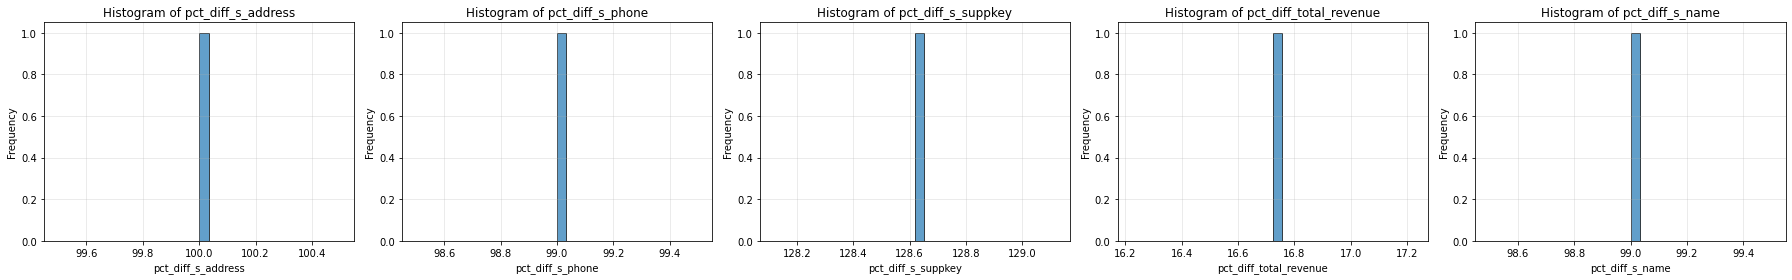

In [104]:

# Get columns that start with 'pct_diff'
pct_diff_cols = [col for col in merged_df.columns if col.startswith('pct_diff_')]

# Create subplots based on number of pct_diff columns
n_cols = len(pct_diff_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))

# Handle case where there's only one column (axes won't be a list)
if n_cols == 1:
    axes = [axes]

# Create histogram for each column
for i, col in enumerate(pct_diff_cols):
    # Convert to pandas for easier plotting, or use polars plot method
    values = merged_df[col].to_pandas()

    axes[i].hist(values, bins=30, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'figs/mi_1_2/q{query_ind}_{col}_hist.png', facecolor='white', bbox_inches='tight')

for base in null_info:
    (nulls_exist, null_inds, null_vals) = null_info[base]
    if nulls_exist:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
        axes = [axes]
        axes[0].hist(null_vals, bins=30, alpha=0.7, edgecolor='black')
        axes[0].set_title(f'Histogram of nulls for column {base}')
        axes[0].set_xlabel('Fraction of nulls (%)')
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True, alpha=0.3)
        plt.savefig(f'figs/mi_1_2/q{query_ind}_{base}_nulls.png', facecolor='white', bbox_inches='tight')

In [110]:
set(merged_df[0]['s_name_noised'].to_list()[0])

{'Supplier#000000073',
 'Supplier#000000091',
 'Supplier#000000134',
 'Supplier#000000150',
 'Supplier#000000154',
 'Supplier#000000164',
 'Supplier#000000170',
 'Supplier#000000182',
 'Supplier#000000185',
 'Supplier#000000187',
 'Supplier#000000199',
 'Supplier#000000207',
 'Supplier#000000218',
 'Supplier#000000220',
 'Supplier#000000228',
 'Supplier#000000230',
 'Supplier#000000238',
 'Supplier#000000300',
 'Supplier#000000315',
 'Supplier#000000378',
 'Supplier#000000379',
 'Supplier#000000397',
 'Supplier#000000402',
 'Supplier#000000422',
 'Supplier#000000423',
 'Supplier#000000425',
 'Supplier#000000445',
 'Supplier#000000459',
 'Supplier#000000463',
 'Supplier#000000468',
 'Supplier#000000574',
 'Supplier#000000590',
 'Supplier#000000626',
 'Supplier#000000634',
 'Supplier#000000656',
 'Supplier#000000657',
 'Supplier#000000677',
 'Supplier#000000679',
 'Supplier#000000696',
 'Supplier#000000718',
 'Supplier#000000722',
 'Supplier#000000731',
 'Supplier#000000735',
 'Supplier#